In [1]:
import os
MODEL_PATH = os.path.join("Model", f"bidirectional_lstm_NN.h5")

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast

In [3]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import nltk
from nltk.data import find
import warnings
warnings.filterwarnings(action ='ignore')

In [4]:
import tensorflow as tf 
from tensorflow.python.client import device_lib
tf.debugging.set_log_device_placement(True)
gpus =tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

In [5]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to C:\Users\Imad
[nltk_data]     Eddine Hajjane\AppData\Roaming\nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


True

In [6]:
tqdm.pandas()

In [7]:
dataframe = pd.read_csv(os.path.join("..", "..", "content", "clean_tweet_topics.csv"))[["id", "text", "topics"]]
dataframe['topics'] = dataframe['topics'].progress_apply(lambda x: ast.literal_eval(x))

100%|██████████| 55327/55327 [00:00<00:00, 63797.10it/s]


In [8]:
labels = np.array(dataframe['topics'].tolist())
X = dataframe["text"]

In [9]:
print(labels.shape)
print(X.shape)

(55327, 11)
(55327,)


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False, sublinear_tf=True, dtype=np.float32)
vectors = vectorizer.fit_transform(X)
terms = vectorizer.get_feature_names_out()

# Create an index

In [11]:
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 300

In [12]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False, k=300):
    embeddings = clean_comments.apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing, k=k))
    return list(embeddings)

In [13]:
word2vec = KeyedVectors.load_word2vec_format(str(find('models/word2vec_sample/pruned.word2vec.txt')), binary=False)

In [14]:
training_embeddings = get_word2vec_embeddings(word2vec, X.apply(lambda x : x.split()), generate_missing=True, k=EMBEDDING_DIM)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.15, random_state=42)

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

oov_tok = ''
embedding_dim = EMBEDDING_DIM
max_length = MAX_SEQUENCE_LENGTH
padding_type='post'
trunc_type='post'
tokenizer = Tokenizer(num_words = len(terms), oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index


train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [17]:
train_embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(36617, 300)


In [18]:
train_padded.shape

(47027, 300)

# Create NN Model (bidirectional lstm + NN)

In [19]:
class Bi_lstm_nn:
    def __init__(self, unit=64, input_shape=(1, 24)):
        self.kernel_initializer = "lecun_normal"
        self.activation = "selu"
        self.forward_layer = tf.keras.layers.LSTM(unit, return_sequences=True)
        self.backward_layer = tf.keras.layers.LSTM(unit, go_backwards=True, return_sequences=True)
        self.bidirectional = tf.keras.layers.Bidirectional(self.forward_layer, backward_layer=self.backward_layer, merge_mode='concat')
        self.bidirectional2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(unit),  merge_mode='concat')
        self.model = tf.keras.models.Sequential()

    def dense_selu(self, num_hidden_layers):
        for _ in range(num_hidden_layers):
            self.model.add(tf.keras.layers.Dense(64, activation=self.activation , kernel_initializer=self.kernel_initializer))
            self.model.add(tf.keras.layers.BatchNormalization())
    
    def build(self, embedding_dim, max_length, vocab_size, embeddings, output_size):
        self.model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim,  weights=[embeddings], input_length=max_length, trainable=True))
        self.model.add(self.bidirectional)
        self.model.add(self.bidirectional2)
        self.dense_selu(3)
        self.model.add(tf.keras.layers.Dense(output_size, activation=tf.keras.activations.softmax))
        return self.model


# Compile & training 

In [20]:
bi_lstm_nn = Bi_lstm_nn().build(embedding_dim, max_length, len(word_index)+1, train_embedding_weights, labels.shape[1])
_ = bi_lstm_nn.compile(loss=tf.keras.losses.binary_crossentropy,\
                 optimizer=tf.keras.optimizers.Adam(),\
                 metrics=['accuracy'])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executin

Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomNormalV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Qr in device /jo

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localh

In [21]:
tt = bi_lstm_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          10985100  
                                                                 
 bidirectional (Bidirectiona  (None, 300, 128)         186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                        

In [33]:
%%time 
history = bi_lstm_nn.fit(train_padded, y_train, epochs=100, validation_split=0.1, shuffle=True,\
                     callbacks=[tf.keras.callbacks.ModelCheckpoint(f"{MODEL_PATH}", save_best_only=True),\
                                tf.keras.callbacks.ReduceLROnPlateau(factor=tf.math.exp(-0.1), patience=50, min_lr=0.00001)])



Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Exp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
  18/1323 [..............................] - ETA: 1:08 - loss: 0.2394 - accuracy: 1.0000Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
  19/1323 [..............................] - ETA: 1:08 - loss: 0.2393 - accuracy: 1.0000Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loca

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
  43/1323 [..............................] - ETA: 1:04 - loss: 0.2397 - accuracy: 0.9993Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
  45/1323 [>.............................] - ETA: 1:04 - loss: 0.2395 - accuracy: 0.9986Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loca

  69/1323 [>.............................] - ETA: 1:01 - loss: 0.2397 - accuracy: 0.9986Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
  71/1323 [>.............................] - ETA: 1:01 - loss: 0.2396 - accuracy: 0.9987Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /jo

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
  97/1323 [=>............................] - ETA: 58s - loss: 0.2393 - accuracy: 0.9987Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
  99/1323 [=>............................] - ETA: 58s - loss: 0.2394 - accuracy: 0.9984Executing op ReadVariableOp in device /job:

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 124/1323 [=>............................] - ETA: 57s - loss: 0.2395 - accuracy: 0.9987Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 126/1323 [=>............................] - ETA: 56s - loss: 0.2395 - accuracy: 0.9988Executing op ReadVariableOp in device /job:

 150/1323 [==>...........................] - ETA: 55s - loss: 0.2393 - accuracy: 0.9981Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 152/1323 [==>...........................] - ETA: 55s - loss: 0.2393 - accuracy: 0.9981Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:

Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 178/1323 [===>..........................] - ETA: 54s - loss: 0.2393 - accuracy: 0.9984Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 180/1323 [===>..............

 204/1323 [===>..........................] - ETA: 52s - loss: 0.2393 - accuracy: 0.9982Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 206/1323 [===>..........................] - ETA: 52s - loss: 0.2394 - accuracy: 0.9982Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 232/1323 [====>.........................] - ETA: 50s - loss: 0.2393 - accuracy: 0.9981Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 234/1323 [====>.........................] - ETA: 50s - loss: 0.2394 - accuracy: 0.9981Executing op ReadVariableOp in device /job:

 258/1323 [====>.........................] - ETA: 49s - loss: 0.2393 - accuracy: 0.9982Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 260/1323 [====>.........................] - ETA: 49s - loss: 0.2393 - accuracy: 0.9982Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 286/1323 [=====>........................] - ETA: 48s - loss: 0.2393 - accuracy: 0.9980Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 288/1323 [=====>........................] - ETA: 48s - loss: 0.2393 - accuracy: 0.9980Executing op ReadVariableOp in device /job:

Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 313/1323 [======>.......................] - ETA: 47s - loss: 0.2393 - accuracy: 0.9981Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 315/1323 [======>...........

Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 340/1323 [======>.......................] - ETA: 45s - loss: 0.2392 - accuracy: 0.9983Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 342/1323 [======>...........

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 366/1323 [=======>......................] - ETA: 44s - loss: 0.2392 - accuracy: 0.9982Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 368/1323 [=======>......................] - ETA: 44s - loss: 0.2392 - accuracy: 0.9981Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localh

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 393/1323 [=======>......................] - ETA: 43s - loss: 0.2393 - accuracy: 0.9982Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 395/1323 [=======>......................] - ETA: 43s - loss: 0.2393 - accuracy: 0.9982Executing op ReadVariableOp in device /job:

Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 419/1323 [========>.....................] - ETA: 42s - loss: 0.2392 - accuracy: 0.9981Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 421/1323 [========>.....................] - ETA: 42s - loss: 0.2392 - accuracy: 0.9981Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_116

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 447/1323 [=========>....................] - ETA: 40s - loss: 0.2392 - accuracy: 0.9981Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_11687 in device /job:localhost/replica:0/task:0/device:GPU:0
 448/1323 [=========>....................] - ETA: 40s - loss: 0.2392 - accuracy: 0.9981Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localh

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

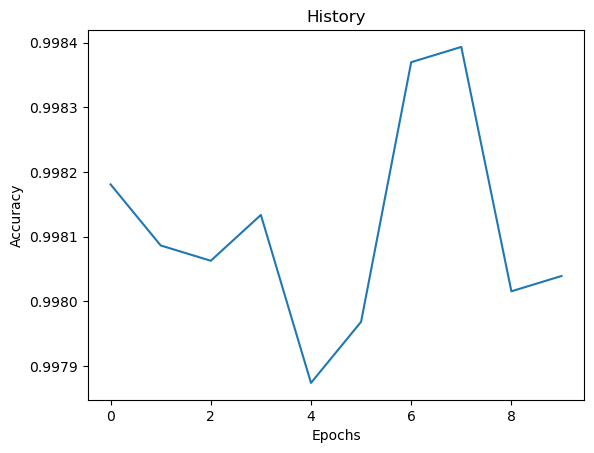

In [34]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title("History")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Evaluate 

In [35]:
eval_ =bi_lstm_nn.evaluate(test_padded, y_test)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Opt

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
 20/260 [=>............................] - ETA: 5s - loss: 0.2391 - accuracy: 1.0000Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job

Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
 50/260 [====>.........................] - ETA: 4s - loss: 0.2385 - accuracy: 0.9994Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in devic

 76/260 [=======>......................] - ETA: 4s - loss: 0.2387 - accuracy: 0.9996Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
 79/260 [========>.....................] - ETA: 3s - loss: 0.2385 - accuracy: 0.9996Executing op ReadVariableOp in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
105/260 [===========>..................] - ETA: 3s - loss: 0.2385 - accuracy: 0.9994Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job

Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
135/260 [==============>...............] - ETA: 2s - loss: 0.2387 - accuracy: 0.9988Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in devic

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
162/260 [=================>............] - ETA: 2s - loss: 0.2388 - accuracy: 0.9990Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job

Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
192/260 [=====================>........] - ETA: 1s - loss: 0.2387 - accuracy: 0.9992Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in devic

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
219/260 [========================>.....] - ETA: 0s - loss: 0.2386 - accuracy: 0.9991Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job

Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
249/260 [===========================>..] - ETA: 0s - loss: 0.2388 - accuracy: 0.9992Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_18921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in devic

In [36]:
eval_[1]

0.9992771148681641

In [37]:
bi_lstm_nn.save(f"{MODEL_PATH}")

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc